# Initial Prediction 


In [55]:

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime, time


In [56]:
#denoising

import pywt

def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    # univeral threshold
    uthresh = 10
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

In [57]:
#Loading continuous_factory_process.csv
df = pd.read_csv('data/continuous_factory_process.csv', delimiter=',')
df.dataframeName = 'continuous_factory_process.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 14088 rows and 116 columns


In [58]:
# deleting the first column

df1 = df.drop(columns = ['time_stamp'], axis = 1)

# checking the shape of the data after deleting a column
df1.shape

(14088, 115)

In [59]:
#filter the y variables (Output measurement actuals) for prediction 

df2=df1.filter(regex='Stage1', axis=1).filter(regex='Actual', axis=1)


In [60]:
#create list of columns names for x and y separation
ylist=df2.columns.to_list()


In [61]:
# separating the dependent and independent data
X=df1.drop(ylist, axis=1)


# Removal of null values

In [64]:
#loop creating a dataframe for each y target while removing zeroes (noise) of y targets
y_dataframe_list=[]
X_dataframe_list=[]

for n in ylist:
    #y data
    y_dataframe=df[[n]]
    y_dataframe=y_dataframe[(y_dataframe.T > 0.01).any()]
    y_dataframe_list.append(y_dataframe)
    
    #X data
    X_dataframe = X[X.index.isin(y_dataframe.index)]
    X_dataframe_list.append(X_dataframe)
    
    

# Denoising X and Y Matrices

In [176]:
# denoising the X Matrix
for n in range(len(ylist)):
    X_denoised=denoise_signal_simple(X_dataframe_list[n])
    X_denoised=pd.DataFrame(X_denoised)
    X_dataframe_list[n]=X_denoised

In [77]:
#denoising the Y matrix FOR PROPHET ONLY
Y_denoised_list=[]
for n in range(len(ylist)):
    Y_denoised=denoise_signal_simple(y_dataframe_list[n])
    y_dataframe_list[n]['denoised']=Y_denoised
    Y_denoised_list.append(y_dataframe_list[n])
    
    y_dataframe_list[n]=y_dataframe_list[n].drop(['denoised'], axis=1)
    Y_denoised_list[n]= Y_denoised_list[n].drop([ylist[n]], axis=1)

# Feature Pruning and Test Splitting


In [177]:
#Unsupervised Feature pruning
from sklearn.decomposition import PCA

pca = PCA(n_components=35)


for n in range(len(ylist)):
    X_dataframe_list[n] = pca.fit_transform(X_dataframe_list[n])


In [178]:
# splitting them into train test and split each 15 

from sklearn.model_selection import train_test_split

X_train_list=[]
X_test_list=[]
y_train_list=[]
y_test_list=[]

#forward loop creates a list of 15 y (pandas series)
for n in range(len(ylist)):  
    X_train, X_test, y_train, y_test = train_test_split(X_dataframe_list[n], y_dataframe_list[n], test_size = 0.2, random_state = 0)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    
    X_train_list.append(X_train)
    X_test_list.append(X_test)


    # getting  shapes of data
print("shape of x_train: ", X_train.shape)
print("shape of x_test: ", X_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)
print("length of y_train_list: ", len(y_train_list))

shape of x_train:  (7256, 35)
shape of x_test:  (1815, 35)
shape of y_train:  (7256, 1)
shape of y_test:  (1815, 1)
length of y_train_list:  15


In [179]:
# standardization of X variables

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
for n in range(len(ylist)): 
    X_train_list[n] = sc.fit_transform(X_train_list[n])
    X_test_list[n] = sc.transform(X_test_list[n])

# Creating the Model

In [11]:
#Creating the Model

import xgboost as xgb
    from xgboost.sklearn import XGBRFClassifier
from xgboost.sklearn import XGBRFRegressor
from xgboost.sklearn import XGBRegressor

model = XGBRegressor(nthread=12, max_depth=7, n_estimators=200,objective ='reg:squarederror') #nthreads allows more core usage

model_list=[]
y_pred_list=[]

#run time without nthread = 8:29
#run time with nthread = 2:02
#run time with nthread and dimensional reduction 1:30
#run time for entire 15 variables 23:21
#ymodel fits
for n in range(len(ylist)):
    model.fit(X_train_list[n], y_train_list[n].values.ravel())
    y_pred = model.predict(X_test_list[n])
    #add to list
    model_list.append(model)
    y_pred_list.append(y_pred)

In [12]:
from sklearn.metrics import mean_squared_error
#Finding the RMSE and chi2 score
RMSE_list=[]

for n in range(len(ylist)):
    MSE = mean_squared_error(y_test_list[n], y_pred_list[n])
    RMSE=np.sqrt(MSE)
    RMSE_list.append(RMSE)

In [175]:
RMSE_list


[0.19848361463951536,
 0.2528306499819954,
 0.28340087675109604,
 0.3878495338731139,
 0.4955290625969341,
 0.14554434859792206,
 0.4591390307428427,
 0.113247667728425,
 0.39558297574687384,
 0.1315572940495387,
 0.06415410998101957,
 0.0835925095473713,
 0.0406677817238513,
 0.25726138694533657,
 0.3524026443219935]

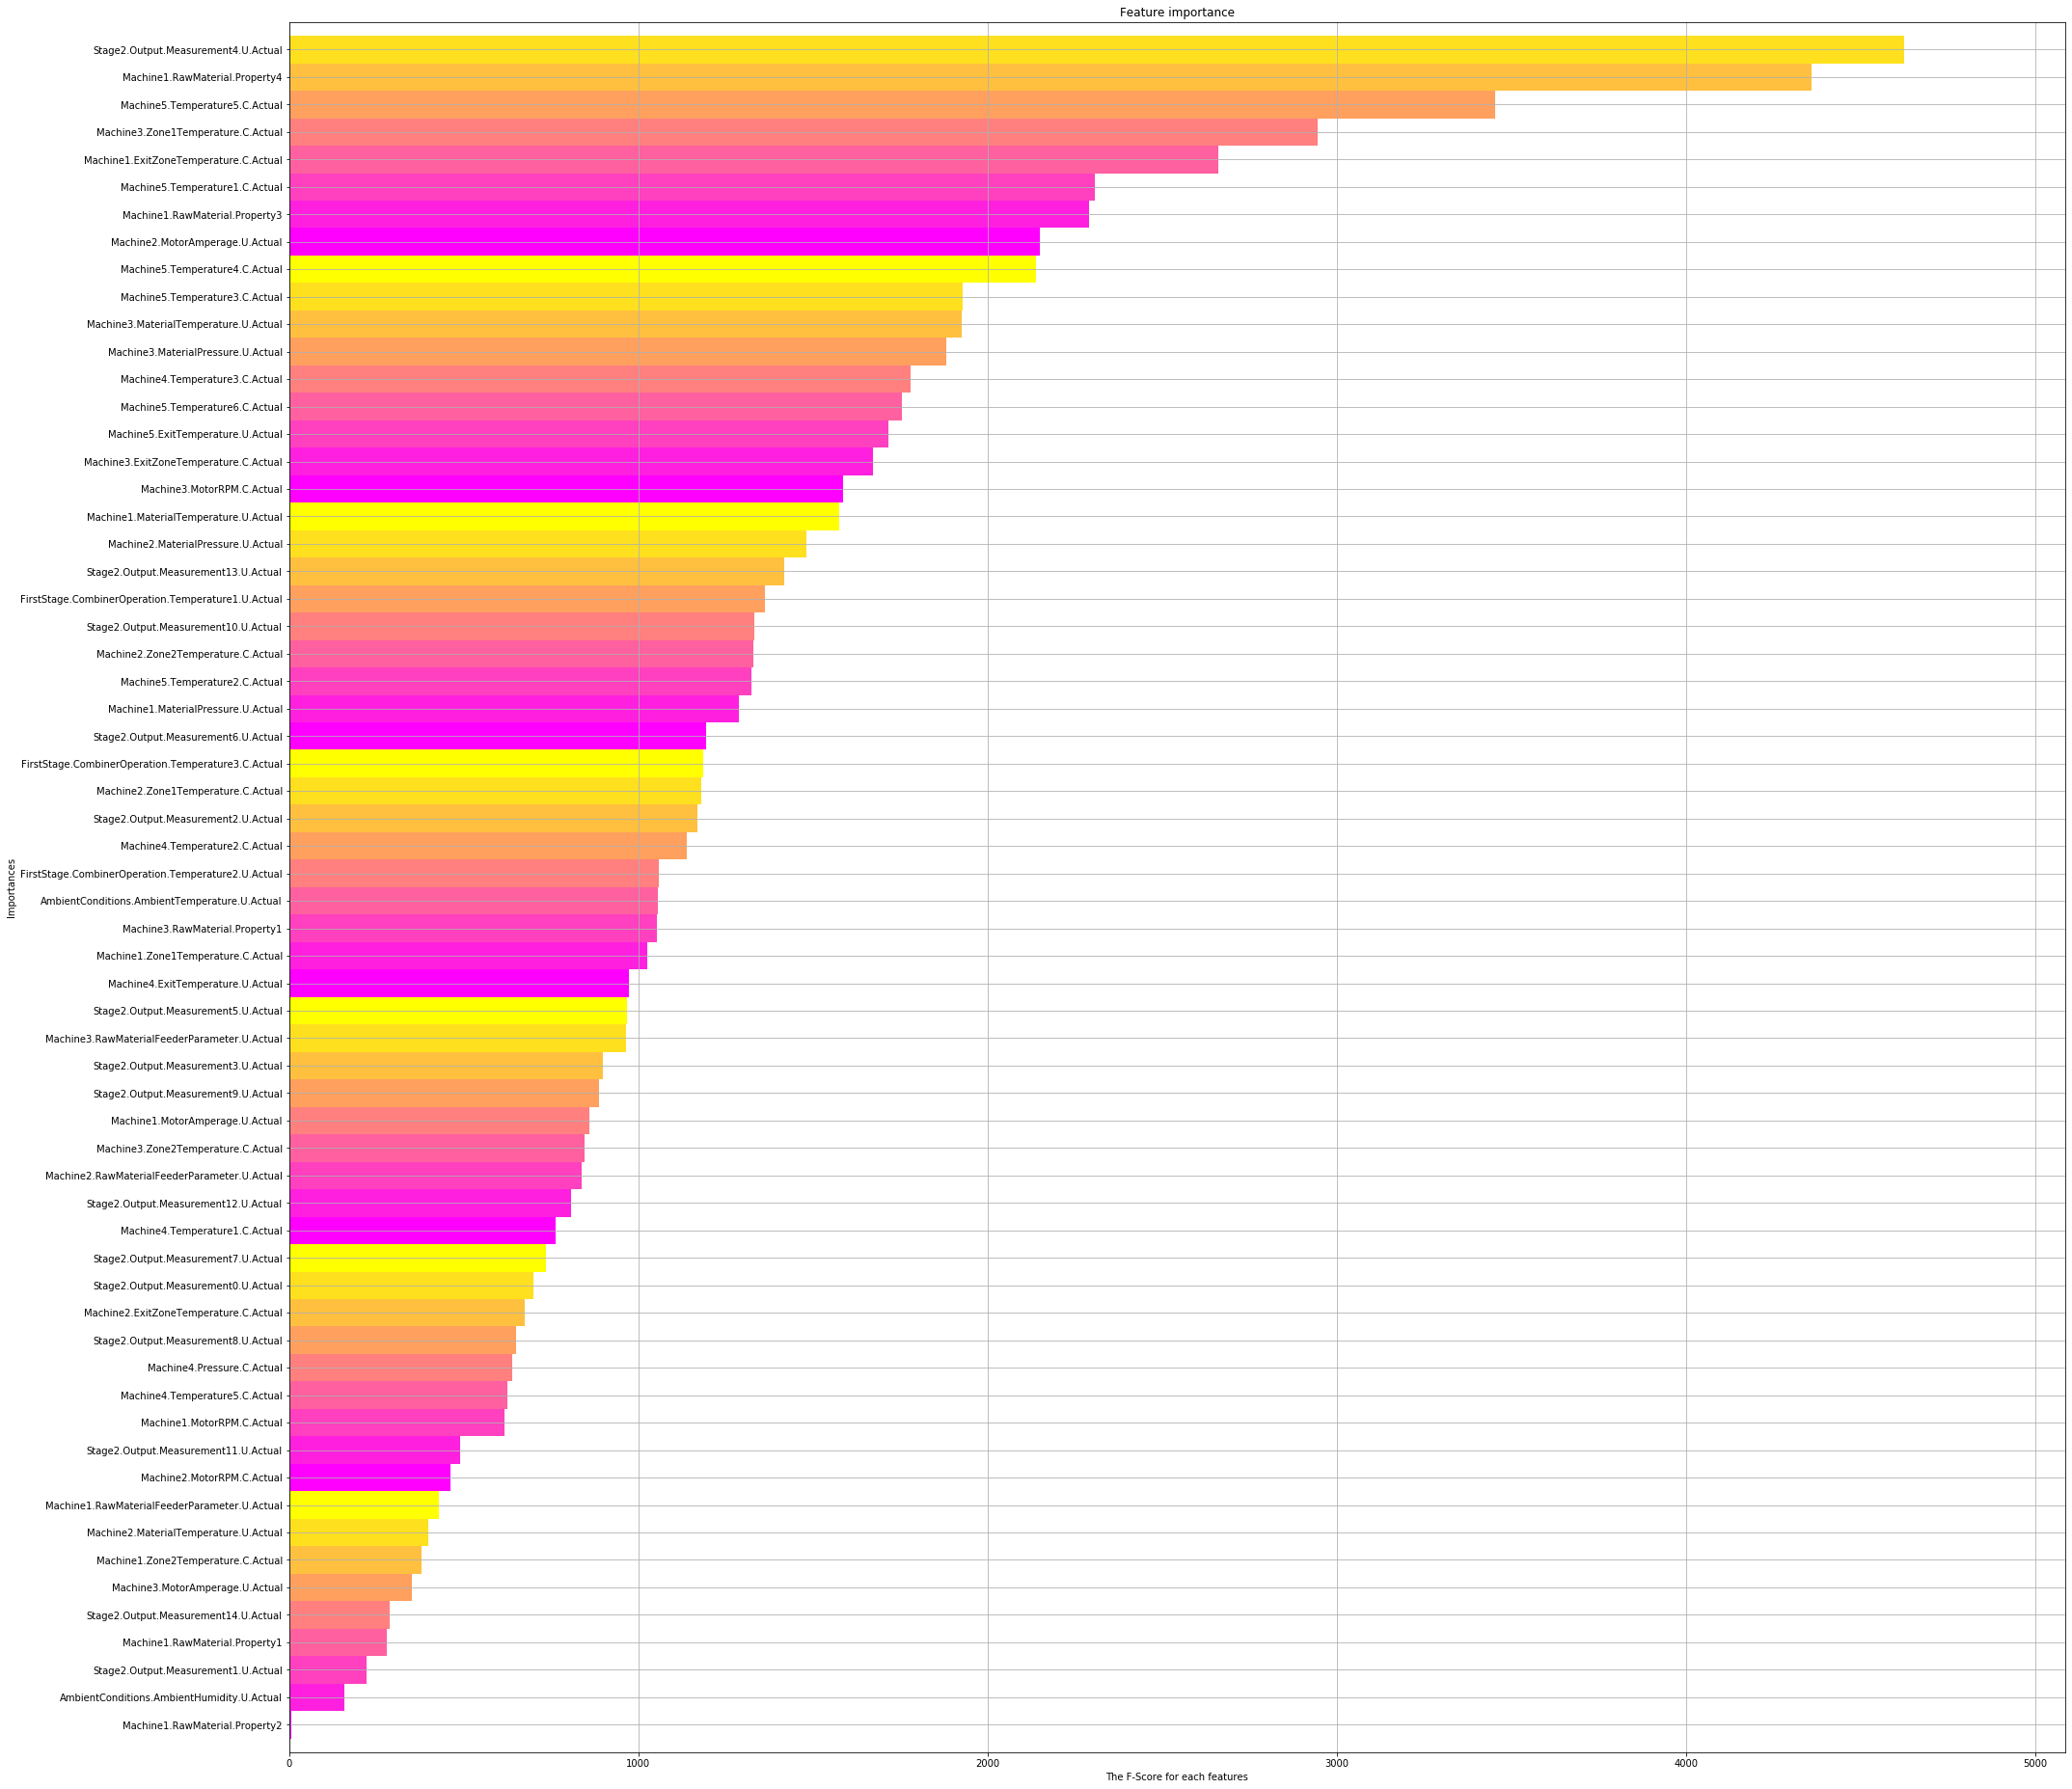

In [88]:
#Significance testing
# Bar plotting feature importances

colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model_list[0], height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (33, 33)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

# Prediction horizon

In [78]:

from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd
import fbprophet

from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter

In [79]:
#loop prophet model creation and dataframe creation with time stamp addition

mlist=[]
df3list=[]

for n in range(len(ylist)):
    #y data
    m = fbprophet.Prophet(changepoint_prior_scale=0.4)
    
    df3=Y_denoised_list[n]
    df3=df3.merge(df[['time_stamp']],right_index=True, left_index=True)
    df3.columns = ['y','ds']
    df3list.append(df3)
    mlist.append(m)

In [80]:
Y_denoised_list[0]

,denoised
0,12.72
1,12.34
2,12.34
3,12.34
4,12.29
...,...
14083,12.61
14084,12.61
14085,12.61
14086,12.58


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13
14


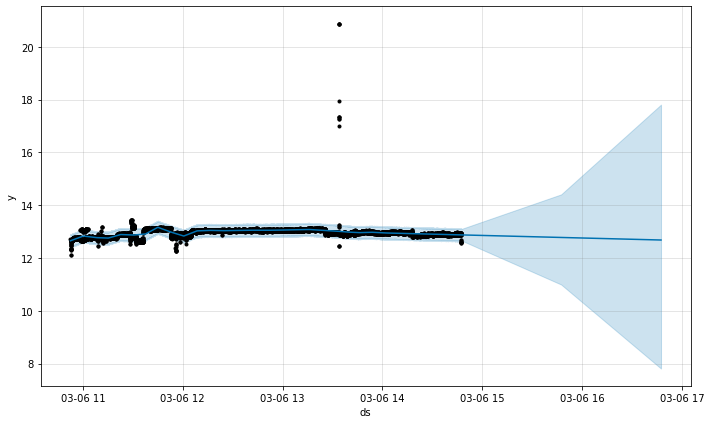

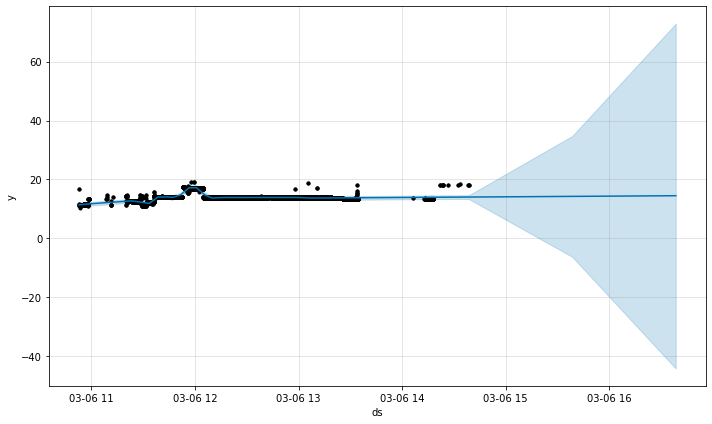

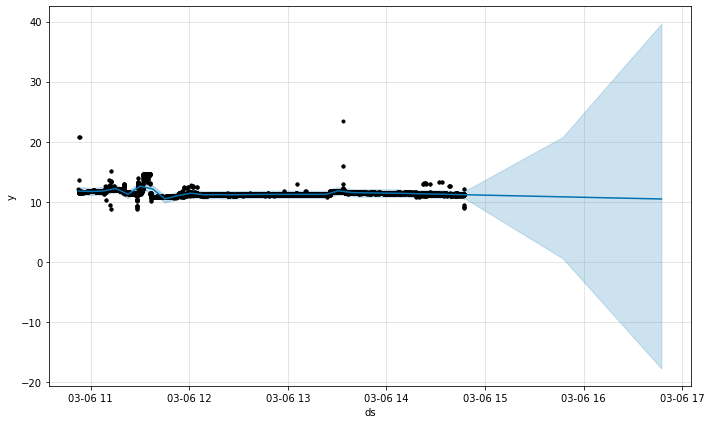

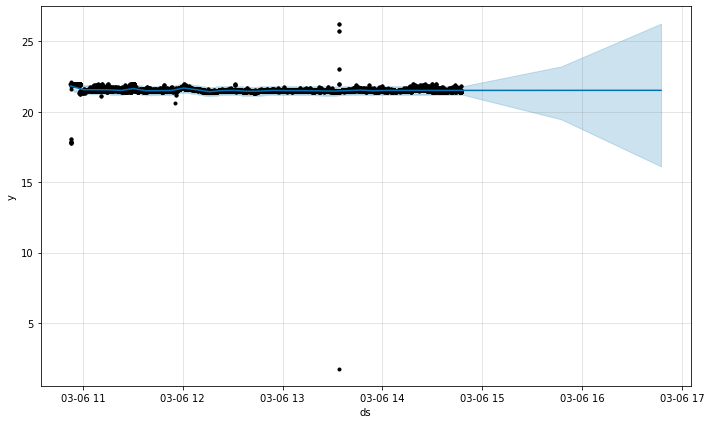

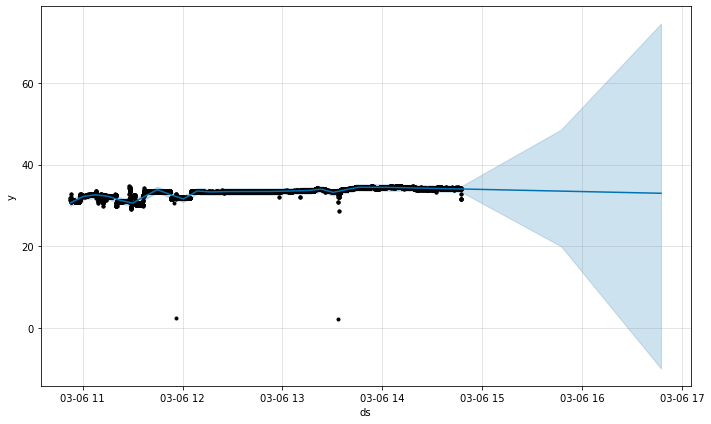

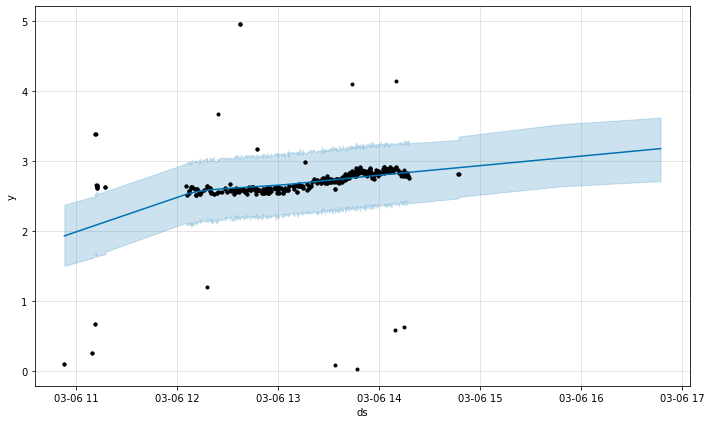

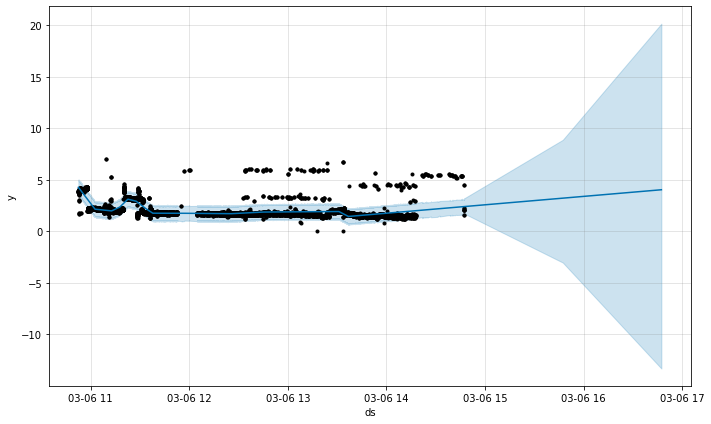

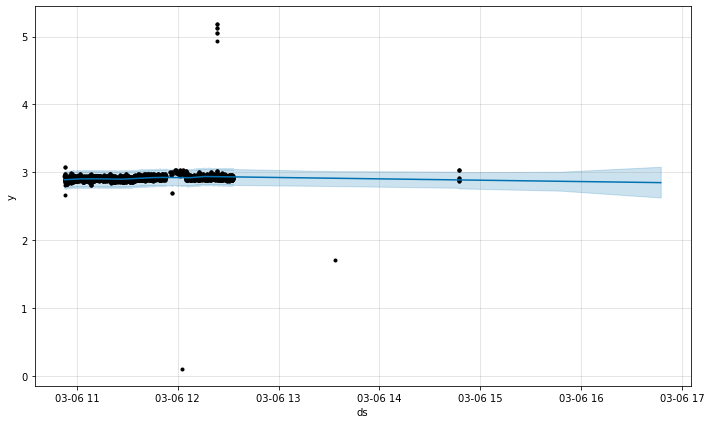

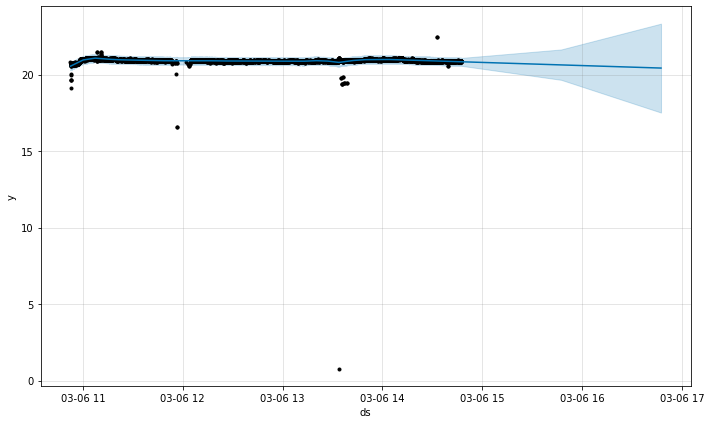

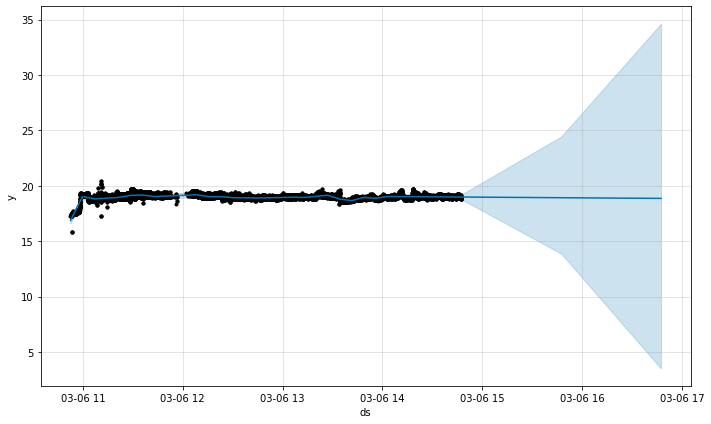

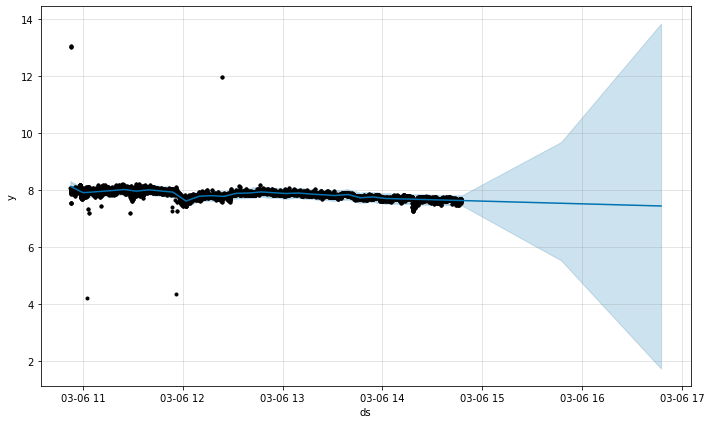

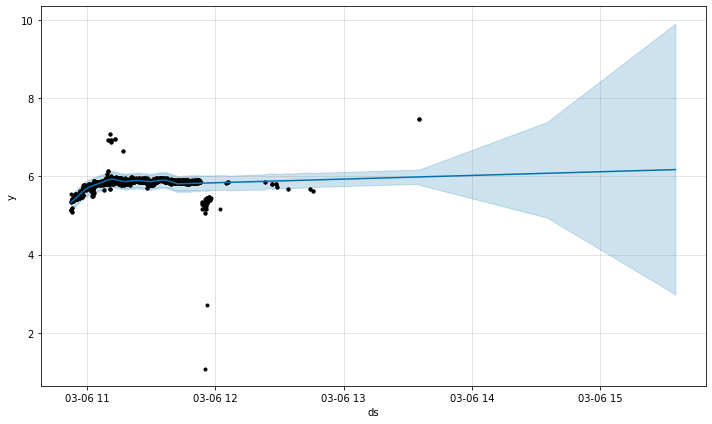

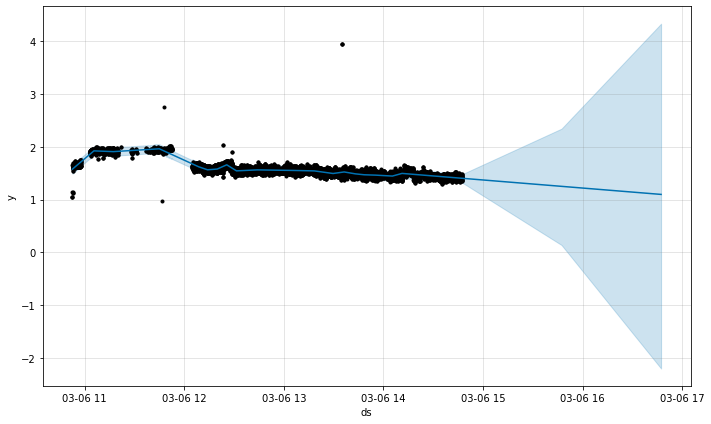

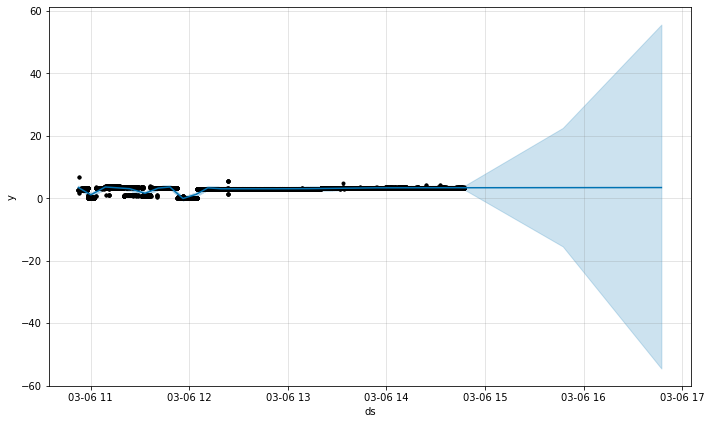

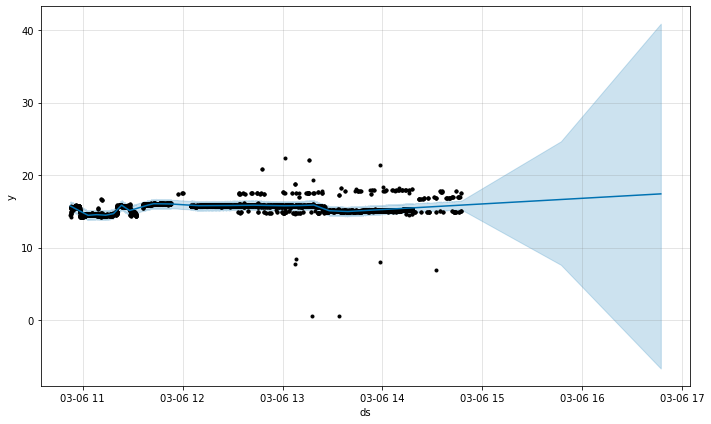

In [81]:
futurelist=[]
forecastlist=[]


for n in range(len(ylist)):
    mlist[n].fit(df3list[n])
    future = mlist[n].make_future_dataframe(periods=2,freq='h')
    forecast = mlist[n].predict(future)
    fig = mlist[n].plot(forecast)
    
    
    futurelist.append(future)
    forecastlist.append(forecast)
    
    
    print(n)

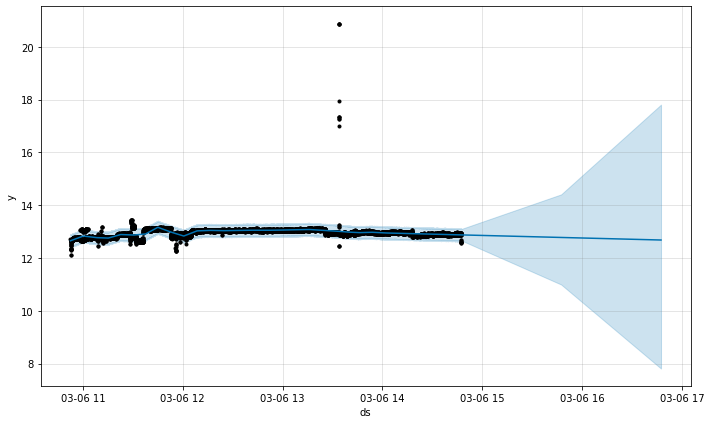

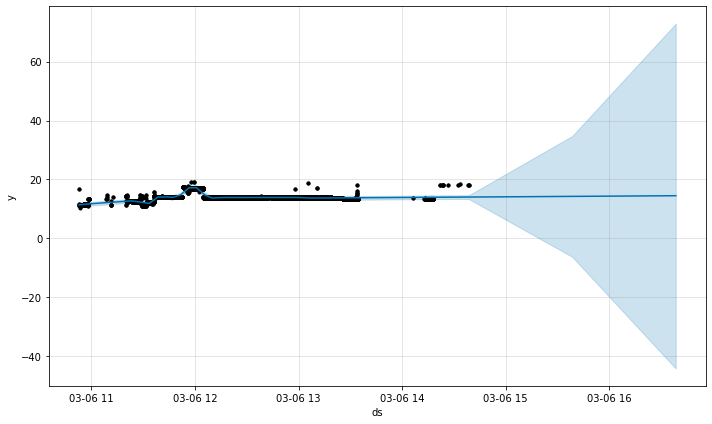

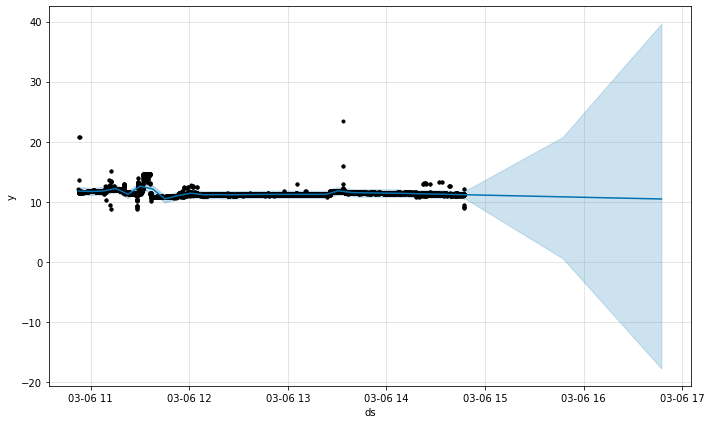

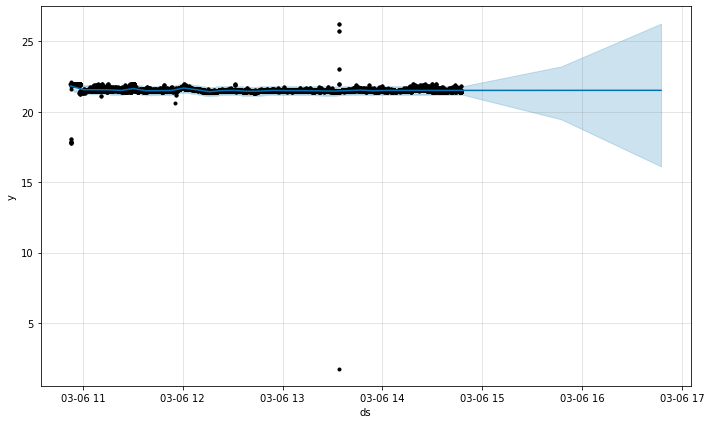

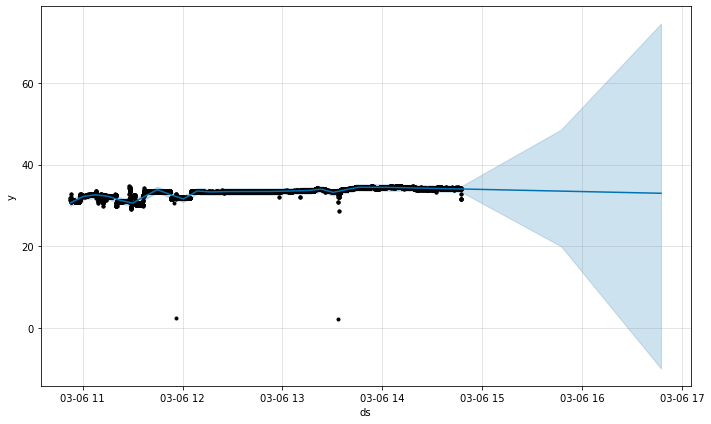

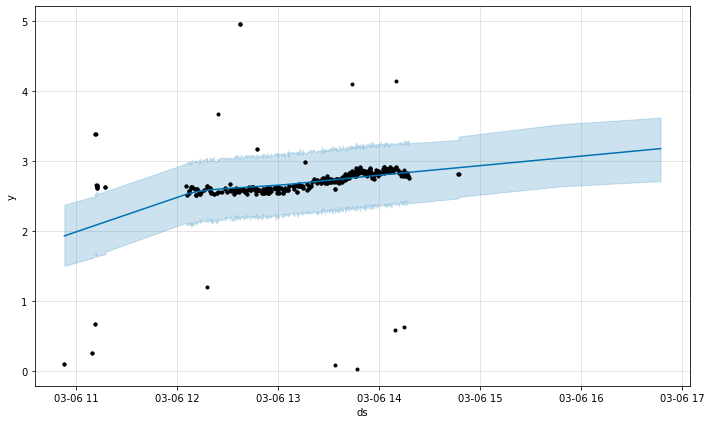

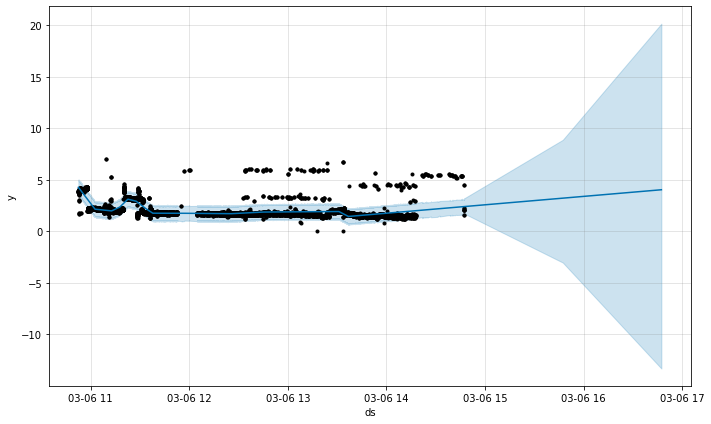

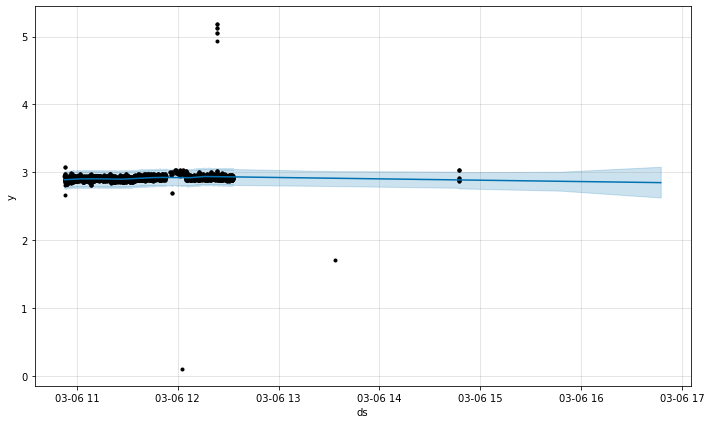

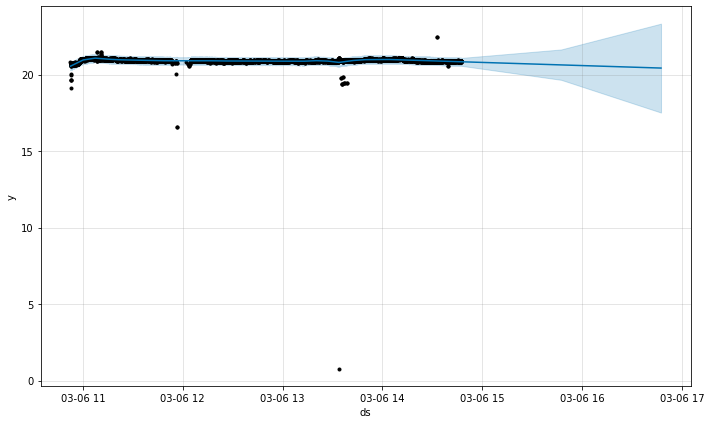

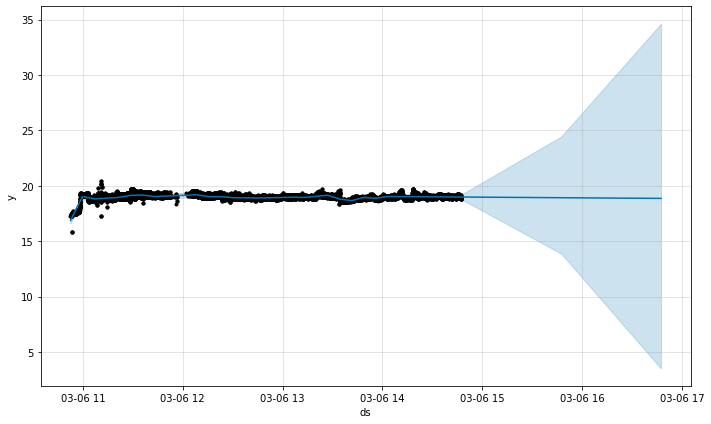

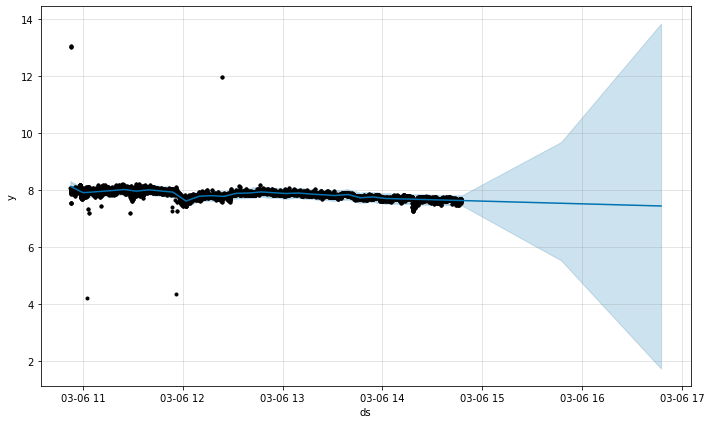

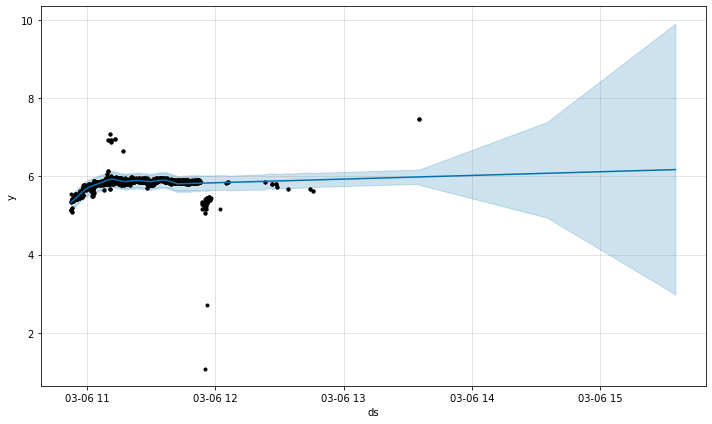

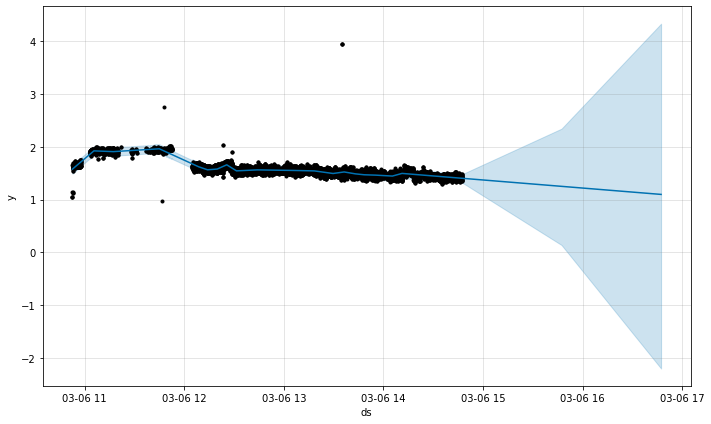

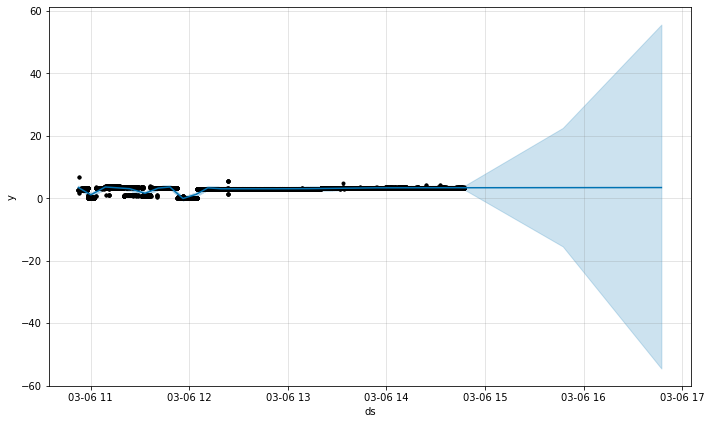

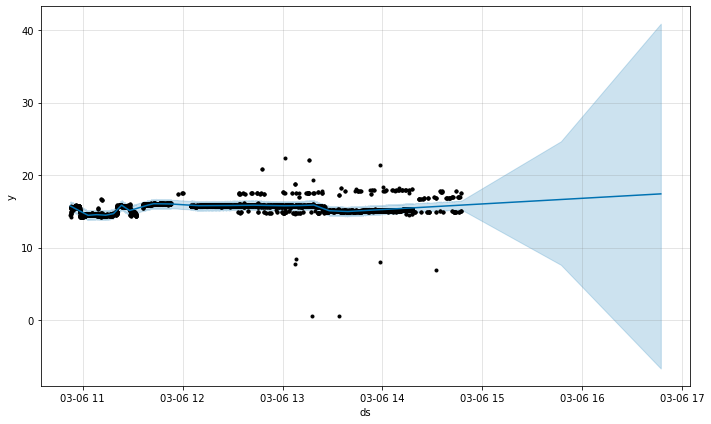

In [82]:
# Predicting the Y
figlist=[]
for n in range(len(ylist)):
    fig = mlist[n].plot(forecastlist[n])
    figlist.append(fig)

In [83]:
type(fig)

matplotlib.figure.Figure

# Scoring Predictions

In [180]:

df_cvlist=[]
from fbprophet.diagnostics import cross_validation
for n in range(len(ylist)):
    df_cv = cross_validation(mlist[n], initial='1 hour', period='1 hour', horizon = '1 hours')
    df_cvlist.append(df_cv)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:38:40 and 2019-03-06 13:38:40
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:11 and 2019-03-06 13:47:11
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-03-06 12:47:20 and 2019-03-06 13:47:20
INFO:fbpro

In [181]:
from fbprophet.diagnostics import performance_metrics
df_plist=[]

for n in range(len(ylist)):
    df_p = performance_metrics(df_cvlist[n])
    df_plist.append(df_p)

In [182]:
crossval=[]

for n in range(len(ylist)):
    dlen=len(df_plist[n])-1
    halflen=.5*len(df_plist[n])
    crossval.append(df_plist[n].iloc[[0,halflen,dlen],[2]])
    

In [185]:
RMSE_df=pd.DataFrame(index=['1 sec', '1800 sec', '3600 sec'])
for n in range(len(ylist)):
    RMSE_df[ylist[n]+' RMSE']=crossval[n].values


In [186]:
RMSE_df

,Stage1.Output.Measurement0.U.Actual RMSE,Stage1.Output.Measurement1.U.Actual RMSE,Stage1.Output.Measurement2.U.Actual RMSE,Stage1.Output.Measurement3.U.Actual RMSE,Stage1.Output.Measurement4.U.Actual RMSE,Stage1.Output.Measurement5.U.Actual RMSE,Stage1.Output.Measurement6.U.Actual RMSE,Stage1.Output.Measurement7.U.Actual RMSE,Stage1.Output.Measurement8.U.Actual RMSE,Stage1.Output.Measurement9.U.Actual RMSE,Stage1.Output.Measurement10.U.Actual RMSE,Stage1.Output.Measurement11.U.Actual RMSE,Stage1.Output.Measurement12.U.Actual RMSE,Stage1.Output.Measurement13.U.Actual RMSE,Stage1.Output.Measurement14.U.Actual RMSE
1 sec,0.045256,0.045425,0.179829,0.083143,0.252813,0.159245,0.469135,1.243112,0.070388,0.172626,0.046963,0.391710,0.048548,0.027604,0.478437
1800 sec,0.073706,0.384739,0.538612,0.138050,0.278443,0.411846,0.978389,0.365957,0.040597,0.478333,0.217354,0.362849,0.088365,0.193767,1.412062
3600 sec,0.171011,1.220842,0.871766,0.261402,0.901822,0.503388,1.407362,0.246082,0.052096,0.594721,0.368101,2.675624,0.149933,0.340422,1.352410
